In [43]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Create the data

In [44]:
A = np.arange(-10, 11, 1)
B = np.arange(-10, 11, 1)

#Création du maillage 
A_grid, B_grid = np.meshgrid(A, B)

# Aplatir les grilles pour en faire des colonnes
A_flat = A_grid.ravel()
B_flat = B_grid.ravel()
C_flat = A_flat + B_flat

# Créer le DataFrame
df = pd.DataFrame({
    'A': A_flat,
    'B': B_flat,
    'C': C_flat
})

print(df.head()) 

    A   B   C
0 -10 -10 -20
1  -9 -10 -19
2  -8 -10 -18
3  -7 -10 -17
4  -6 -10 -16


In [45]:
df.shape

(441, 3)

# Train / test Split and Data loaders

In [46]:
data_np = df.to_numpy()
labels = data_np[:, 2]
data = data_np[:, :2]

# Step 1: convert to tensor
dataT   = torch.tensor( data ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [47]:
# Analyse the Loaders

In [48]:
print(f"Taille du train_loader : {len(train_loader)}")
print(f"Taille du test_loader : {len(test_loader)}")

Taille du train_loader : 12
Taille du test_loader : 1


In [49]:
# Pour le train_loader
for batch_idx, (data, labels) in enumerate(train_loader):
    print("--- Batch d'entraînement ---")
    print(f"Index du batch : {batch_idx}")
    print(f"Shape des données (batch) : {data.shape}")
    print(f"Shape des labels (batch) : {labels.shape}")
    print(f"Exemple de données du batch :\n{data[:5]}")  # Afficher les 5 premiers exemples
    print(f"Exemple de labels du batch :\n{labels[:5]}") # Afficher les 5 premiers labels
    break # Ne récupérer que le premier batch

--- Batch d'entraînement ---
Index du batch : 0
Shape des données (batch) : torch.Size([32, 2])
Shape des labels (batch) : torch.Size([32])
Exemple de données du batch :
tensor([[-1., -4.],
        [ 1.,  2.],
        [ 1., -1.],
        [ 9., -7.],
        [ 2.,  6.]])
Exemple de labels du batch :
tensor([-5,  3,  0,  2,  8])


In [50]:
# Pour le test_loader
for batch_idx, (data, labels) in enumerate(test_loader):
    print("\n--- Batch de test ---")
    print(f"Index du batch : {batch_idx}")
    print(f"Shape des données (batch) : {data.shape}")
    print(f"Shape des labels (batch) : {labels.shape}")
    print(f"Exemple de données du batch :\n{data[:5]}")
    print(f"Exemple de labels du batch :\n{labels[:5]}")
    break 


--- Batch de test ---
Index du batch : 0
Shape des données (batch) : torch.Size([45, 2])
Shape des labels (batch) : torch.Size([45])
Exemple de données du batch :
tensor([[ 9.,  6.],
        [ 1.,  9.],
        [ 5.,  9.],
        [ 7.,  9.],
        [ 1., -3.]])
Exemple de labels du batch :
tensor([15, 10, 14, 16, -2])


# the model

In [51]:
def createRegressionNet():
  class RegressionNet(nn.Module):
    def __init__(self):
      super().__init__()
      ### input layer
      self.input = nn.Linear(2,4)
    
      ### hidden layer
      self.fc1 = nn.Linear(4,8)
      self.fc2 = nn.Linear(8,4)
      ### output layer
      self.output = nn.Linear(4,1)
     # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
    
  # créer le modèle
  net = RegressionNet()
  # fonction de perte adaptée à la régression
  lossfun = nn.MSELoss()
  # optimiseur
  optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
  return net, lossfun, optimizer


In [52]:
# Test the model 
net, _, _ = createRegressionNet()  
test_input = torch.randn(5, 2)     
test_output = net(test_input)     
print(f"Input shape: {test_input.shape}, Output shape: {test_output.shape}")

Input shape: torch.Size([5, 2]), Output shape: torch.Size([5, 1])


# Train the model

In [57]:
def trainRegressionModel(train_loader, test_loader):
    # number of epochs
    numepochs = 60
    
    # create a new model
    net, lossfun, optimizer = createRegressionNet()
    
    # initialize losses
    losses = torch.zeros(numepochs)
    train_losses = []
    test_losses = []
    
    # loop over epochs
    for epochi in range(numepochs):
        # loop over training data batches
        batch_losses = []
        for X, y in train_loader:
            
            y = y.view(-1, 1).float()  
            
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
        
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # loss from this batch
            batch_losses.append(loss.item())
        
        # end of batch loop...
        # get average losses across the batches
        losses[epochi] = np.mean(batch_losses)
        train_losses.append(np.mean(batch_losses))
        
        # test loss
        with torch.no_grad():  
            test_batch_losses = []
            for X, y in test_loader:    
                y = y.view(-1, 1).float()  
                yHat = net(X)
                test_loss = lossfun(yHat, y)
                test_batch_losses.append(test_loss.item())
            
            test_losses.append(np.mean(test_batch_losses))
        
        # Print progress
        if (epochi+1) % 10 == 0:
            print(f'Epoch {epochi+1}/{numepochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')
    
    # end epochs
    # function output
    return train_losses, test_losses, losses, net

# Run model 

Epoch 10/60, Train Loss: 0.2707, Test Loss: 0.2053
Epoch 20/60, Train Loss: 0.0426, Test Loss: 0.0399
Epoch 30/60, Train Loss: 0.0093, Test Loss: 0.0104
Epoch 40/60, Train Loss: 0.0029, Test Loss: 0.0054
Epoch 50/60, Train Loss: 0.0014, Test Loss: 0.0030
Epoch 60/60, Train Loss: 0.0007, Test Loss: 0.0014


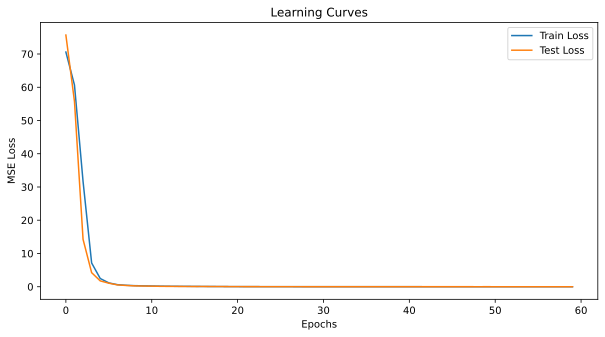

In [58]:
train_losses, test_losses, losses, trained_net = trainRegressionModel(train_loader, test_loader)

# Visualiser les courbes d'apprentissage
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()